In [4]:
# !pip install torch
# pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu{12.6}/torch_stable.html
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# tensor = torch.randn((3, 3))
# tensor = tensor.to('cuda')
#!nvcc --version

## .nc Dateien ##

In [1]:
import xarray
import os
import pandas as pd

def combine_files(path, file_name, file_format:str=".nc"):
    """Combine files of the same dataset with different timestamps. Converts them into a dataframe."""
    df = "a"
    df_new = "a"

    for file in os.listdir(path):
        if file.endswith(file_format) and file_name.lower() in file.lower(): 
            print(file)
            if file_format == ".nc":
                ds = xarray.open_dataset(path + "/" + file)

                if type(df) == type(str()):
                    df = ds.to_dataframe()
                else:
                    df_new = ds.to_dataframe()
            elif file_format == ".csv":
                if type(df) == type(str()):
                    df = pd.read_csv(path + "/" + file)
                else:
                    df_new = pd.read_csv(path + "/" + file)

            if type(df_new) != type(str()):
                df_total = pd.concat([df, df_new])

    return df_total

df_dwd_hornsea = combine_files("nc_files", "dwd_icon_eu_hornsea")
df_dwd_pes = combine_files("nc_files", "dwd_icon_eu_pes10")
df_dwd_demand = combine_files("nc_files", "dwd_icon_eu_demand")

ncep_gfs_hornsea = combine_files("nc_files", "ncep_gfs_hornsea")
ncep_gfs_pes = combine_files("nc_files", "ncep_gfs_pes10")
ncep_gfs_demand = combine_files("nc_files", "ncep_gfs_demand")

dwd_icon_eu_hornsea_1_20200920_20231027.nc
dwd_icon_eu_hornsea_1_20231027_20240108.nc
dwd_icon_eu_hornsea_1_20240108_20240129.nc
dwd_icon_eu_hornsea_1_20240129_20240519.nc
dwd_icon_eu_pes10_20200920_20231027.nc
dwd_icon_eu_pes10_20231027_20240108.nc
dwd_icon_eu_pes10_20240108_20240129.nc
dwd_icon_eu_pes10_20240129_20240519.nc
dwd_icon_eu_demand_20200920_20231027.nc
dwd_icon_eu_demand_20231027_20240108.nc
dwd_icon_eu_demand_20240108_20240129.nc
dwd_icon_eu_demand_20240129_20240519.nc
ncep_gfs_hornsea_1_20200920_20231027.nc
ncep_gfs_hornsea_1_20231027_20240108.nc
ncep_gfs_hornsea_1_20240108_20240129.nc
ncep_gfs_hornsea_1_20240129_20240519.nc
ncep_gfs_pes10_20200920_20231027.nc
ncep_gfs_pes10_20231027_20240108.nc
ncep_gfs_pes10_20240108_20240129.nc
ncep_gfs_pes10_20240129_20240519.nc
ncep_gfs_demand_20200920_20231027.nc
ncep_gfs_demand_20231027_20240108.nc
ncep_gfs_demand_20240108_20240129.nc
ncep_gfs_demand_20240129_20240519.nc


In [11]:
import numpy as np

def preprocess_geo_data(df):
    # reset the index (reference_time, valid_time, latitude, longitude)
    df.reset_index(inplace = True)
    # rename the columns properly
    df = df.rename(columns = {"level_0": "reference_time", "level_1": "valid_time"})
    # convert the datetime information to the right format
    df["reference_time"] = pd.to_datetime(df.reference_time).dt.tz_localize("UTC")
    df["valid_time"] = df["reference_time"] + pd.to_timedelta(df["valid_time"], unit = "hour")
    # remove forecasts which extend beyond the day ahead, since they will be outdated the next day anyway
    df[df["valid_time"] - df["reference_time"] < np.timedelta64(50,"h")]
    # some data points have a miscalculation at their coordinates (e.g. ncep_gfs_demand). The actual coordinates can be identified by their value of the feature "point"
    df.loc[df.longitude > 90, "longitude"] -= 360

    # Fill missing values by using the mean of other data points at a similiar time (same year, month and hour)
    mask = df.isna().any(axis=1)
    # Group by year, month, and hour, then calculate the mean
    grouped_means = df.groupby([df.valid_time.dt.year, df.valid_time.dt.month, df.valid_time.dt.hour]).transform('mean')
    # Fill missing values using the grouped means
    df[mask] = df[mask].fillna(grouped_means)

    # there are anomalies of the solar down radiation being above 1000 in a short time period. The maximum threshold is to be believed to be about 1000 W/m^2
    # source: https://www.researchgate.net/post/Are_there_minimum_and_maximum_threshold_of_solar_irradiance
    if "SolarDownwardRadiation" in df.columns:
        df = df[df["SolarDownwardRadiation"] <= 1000]

    return df

df_dwd_hornsea = preprocess_geo_data(df_dwd_hornsea)
ncep_gfs_hornsea = preprocess_geo_data(ncep_gfs_hornsea)
df_dwd_pes = preprocess_geo_data(df_dwd_pes)
ncep_gfs_pes = preprocess_geo_data(ncep_gfs_pes)
df_dwd_demand = preprocess_geo_data(df_dwd_demand)
ncep_gfs_demand = preprocess_geo_data(ncep_gfs_demand)

Gemeinsame Koordinaten für Hornsea

In [7]:
print("DWD")
print(len(df_dwd_hornsea.latitude.unique()), "verschiedene Breitengradkoordinaten.")
print(len(df_dwd_hornsea.longitude.unique()), "verschiedene Längengradkoordinaten.")
print("NCEP GFS")
print(len(ncep_gfs_hornsea.latitude.unique()), "verschiedene Breitengradkoordinaten.")
print(len(ncep_gfs_hornsea.longitude.unique()), "verschiedene Längengradkoordinaten.")
print("Schnittmenge")
print(len(set([*ncep_gfs_hornsea.latitude.unique(), *df_dwd_hornsea.latitude.unique()])), "verschiedene Breitengradkoordinaten")
print(len(set([*ncep_gfs_hornsea.longitude.unique(), *df_dwd_hornsea.longitude.unique()])), "verschiedene Längengradkoordinaten")

DWD
6 verschiedene Breitengradkoordinaten.
6 verschiedene Längengradkoordinaten.
NCEP GFS
3 verschiedene Breitengradkoordinaten.
3 verschiedene Längengradkoordinaten.
Schnittmenge
8 verschiedene Breitengradkoordinaten
9 verschiedene Längengradkoordinaten


In [8]:
df_dwd_hornsea.set_index("valid_time").resample("24h").std()

reference_time  latitude  longitude  \
valid_time                                                                 
2020-09-20 00:00:00+00:00 0 days 06:00:05.001737501  0.111792   0.111034   
2020-09-21 00:00:00+00:00 0 days 12:04:50.495309859  0.111776   0.111019   
2020-09-22 00:00:00+00:00 0 days 18:42:45.326160960  0.111772   0.111015   
2020-09-23 00:00:00+00:00 1 days 00:16:40.059822693  0.111771   0.111013   
2020-09-24 00:00:00+00:00 1 days 04:38:26.109753404  0.111770   0.111013   
...                                             ...       ...        ...   
2024-05-20 00:00:00+00:00 0 days 23:49:46.060434050  0.111773   0.111015   
2024-05-21 00:00:00+00:00 0 days 19:16:02.512052993  0.111777   0.111019   
2024-05-22 00:00:00+00:00 0 days 13:27:02.845254699  0.111792   0.111034   
2024-05-23 00:00:00+00:00 0 days 06:59:10.190800591  0.111831   0.111073   
2024-05-24 00:00:00+00:00           0 days 00:00:00  0.113352   0.112583   

                           RelativeHumidity  Temperature  WindDirection  \
valid_time                                                                
2020-09-20 00:00:00+00:00          1.960529     0.330594       9.099864   
2020-09-21 00:00:00+00:00          1.820618     0.706420      48.319965   
2020-09-22 00:00:00+00:00          2.998459     0.758538      27.520308   
2020-09-23 00:00:00+00:00          2.827087     0.982319      80.853676   
2020-09-24 00:00:00+00:00          7.305924     0.719218      60.870193   
...                                     ...          ...            ...   
2024-05-20 00:00:00+00:00          4.219320     0.511208      40.629856   
2024-05-21 00:00:00+00:00          3.442949     0.535348     121.852013   
2024-05-22 00:00:00+00:00          2.501889     0.555105     153.935989   
2024-05-23 00:00:00+00:00          1.864942     0.338788      56.478790   
2024-05-24 00:00:00+00:00          0.413635     0.210553       6.848711   

                           WindDirection:100  WindSpeed  WindSpeed:100  
valid_time                                                              
2020-09-20 00:00:00+00:00           9.056569   1.429008       1.798477  
2020-09-21 00:00:00+00:00          49.405712   1.138167       1.388502  
2020-09-22 00:00:00+00:00          27.029186   1.664531       2.814929  
2020-09-23 00:00:00+00:00          81.128113   2.009389       2.402615  
2020-09-24 00:00:00+00:00          60.911514   3.618948       4.326265  
...                                      ...        ...            ...  
2024-05-20 00:00:00+00:00          11.135729   0.947769       0.926851  
2024-05-21 00:00:00+00:00         111.516167   1.235927       1.695624  
2024-05-22 00:00:00+00:00         146.440338   2.965786       3.981278  
2024-05-23 00:00:00+00:00          56.070847   2.271629       2.853354  
2024-05-24 00:00:00+00:00           6.069942   0.264801       0.346910  

[1343 rows x 9 columns]

In [9]:
df_dwd_hornsea.isnull().sum()

reference_time       0
valid_time           0
latitude             0
longitude            0
RelativeHumidity     0
Temperature          0
WindDirection        0
WindDirection:100    0
WindSpeed            0
WindSpeed:100        0
dtype: int64

In [10]:
ncep_gfs_hornsea.isnull().sum()

reference_time       0
valid_time           0
latitude             0
longitude            0
RelativeHumidity     0
Temperature          0
WindDirection        0
WindDirection:100    0
WindSpeed            0
WindSpeed:100        0
dtype: int64

In [11]:
hornsea = pd.concat([df_dwd_hornsea, ncep_gfs_hornsea])

In [12]:
hornsea.dropna(axis = 0, inplace = True)

Gemeinsame Koordinaten für Demand

In [13]:
print("DWD")
print(len(df_dwd_demand.latitude.unique()), "verschiedene Breitengradkoordinaten.")
print(len(df_dwd_demand.longitude.unique()), "verschiedene Längengradkoordinaten.")
print("NCEP GFS")
print(len(ncep_gfs_demand.latitude.unique()), "verschiedene Breitengradkoordinaten.")
print(len(ncep_gfs_demand.longitude.unique()), "verschiedene Längengradkoordinaten.")
print("Schnittmenge")
print(len(set([*ncep_gfs_demand.latitude.unique(), *df_dwd_demand.latitude.unique()])), "verschiedene Breitengradkoordinaten")
print(len(set([*ncep_gfs_demand.longitude.unique(), *df_dwd_demand.longitude.unique()])), "verschiedene Längengradkoordinaten")

DWD
7 verschiedene Breitengradkoordinaten.
7 verschiedene Längengradkoordinaten.
NCEP GFS
7 verschiedene Breitengradkoordinaten.
14 verschiedene Längengradkoordinaten.
Schnittmenge
7 verschiedene Breitengradkoordinaten
14 verschiedene Längengradkoordinaten


In [14]:
demand = pd.concat([df_dwd_demand, ncep_gfs_demand]).groupby(["reference_time", "valid_time", "latitude", "longitude"]).mean()

Gemeinsame Koordinaten für PES

In [15]:
print("DWD")
print(len(df_dwd_pes.latitude.unique()), "verschiedene Breitengradkoordinaten.")
print(len(df_dwd_pes.longitude.unique()), "verschiedene Längengradkoordinaten.")
print("NCEP GFS")
print(len(ncep_gfs_pes.latitude.unique()), "verschiedene Breitengradkoordinaten.")
print(len(ncep_gfs_pes.longitude.unique()), "verschiedene Längengradkoordinaten.")
print("Schnittmenge")
print(len(set([*ncep_gfs_pes.latitude.unique(), *df_dwd_pes.latitude.unique()])), "verschiedene Breitengradkoordinaten")
print(len(set([*ncep_gfs_pes.longitude.unique(), *df_dwd_pes.longitude.unique()])), "verschiedene Längengradkoordinaten")

DWD
19 verschiedene Breitengradkoordinaten.
20 verschiedene Längengradkoordinaten.
NCEP GFS
19 verschiedene Breitengradkoordinaten.
23 verschiedene Längengradkoordinaten.
Schnittmenge
19 verschiedene Breitengradkoordinaten
23 verschiedene Längengradkoordinaten


In [16]:
pes = pd.concat([df_dwd_pes,ncep_gfs_pes]).groupby(["reference_time", "valid_time", "latitude", "longitude", "point"]).mean()

In [17]:
pes.head()

CloudCover  \
reference_time            valid_time                latitude  longitude point               
2020-09-20 00:00:00+00:00 2020-09-20 00:00:00+00:00 51.875051  0.911503 14       0.127510   
                                                    51.956370  0.658817 4        0.166816   
                                                    52.024023  0.296268 12       0.205625   
                                                    52.067943  1.175175 11       0.083994   
                                                    52.078072 -0.011349 19       0.216973   

                                                                               SolarDownwardRadiation  \
reference_time            valid_time                latitude  longitude point                           
2020-09-20 00:00:00+00:00 2020-09-20 00:00:00+00:00 51.875051  0.911503 14                        0.0   
                                                    51.956370  0.658817 4                         0.0   
                                                    52.024023  0.296268 12                        0.0   
                                                    52.067943  1.175175 11                        0.0   
                                                    52.078072 -0.011349 19                        0.0   

                                                                               Temperature  
reference_time            valid_time                latitude  longitude point               
2020-09-20 00:00:00+00:00 2020-09-20 00:00:00+00:00 51.875051  0.911503 14       14.472824  
                                                    51.956370  0.658817 4        13.826828  
                                                    52.024023  0.296268 12       12.994598  
                                                    52.067943  1.175175 11       15.247726  
                                                    52.078072 -0.011349 19       12.542252

In [18]:
pes[["CloudCover", "SolarDownwardRadiation", "Temperature"]].corr()

CloudCover  SolarDownwardRadiation  Temperature
CloudCover                1.000000               -0.168385     0.035698
SolarDownwardRadiation   -0.168385                1.000000     0.448383
Temperature               0.035698                0.448383     1.000000

In [19]:
hornsea[["RelativeHumidity", "Temperature", "WindDirection", "WindDirection:100", "WindSpeed", "WindSpeed:100"]].corr()

RelativeHumidity  Temperature  WindDirection  \
RelativeHumidity           1.000000     0.219995      -0.076622   
Temperature                0.219995     1.000000      -0.017328   
WindDirection             -0.076622    -0.017328       1.000000   
WindDirection:100         -0.065326    -0.010354       0.966396   
WindSpeed                 -0.129688    -0.224788       0.152949   
WindSpeed:100             -0.010466    -0.169534       0.138276   

                   WindDirection:100  WindSpeed  WindSpeed:100  
RelativeHumidity           -0.065326  -0.129688      -0.010466  
Temperature                -0.010354  -0.224788      -0.169534  
WindDirection               0.966396   0.152949       0.138276  
WindDirection:100           1.000000   0.145375       0.136285  
WindSpeed                   0.145375   1.000000       0.973386  
WindSpeed:100               0.136285   0.973386       1.000000

Features zu machen oder Überlegung

- Windstärkekategorie
- Interaktion (Solar*Temperatur?)
- täglicher Durchschnitt von Solar, Temperatur, Windgeschwindigkeit, Windrichtung, Luftfeuchtigkeit
- Temperaturreichweite/ Windgeschwindigkeitsreichweite
- Maximum/ Minimum Temp, Windgeschwindigkeit, Solar
- tägliche Std.abweichung von Windgeschwindigkeit, Temperatur, Solar
- Precipiation/ Fällung: durchschnittliche Regenmenge innerhalb eines Niederschlags, Stunden mit/ohne Regen

In [20]:
pes.columns

Index(['CloudCover', 'SolarDownwardRadiation', 'Temperature'], dtype='object')

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.scatterplot(pes, x = "valid_time", y = "SolarDownwardRadiation", s = 5)

Visualisierung auf der Karte

<Axes: >

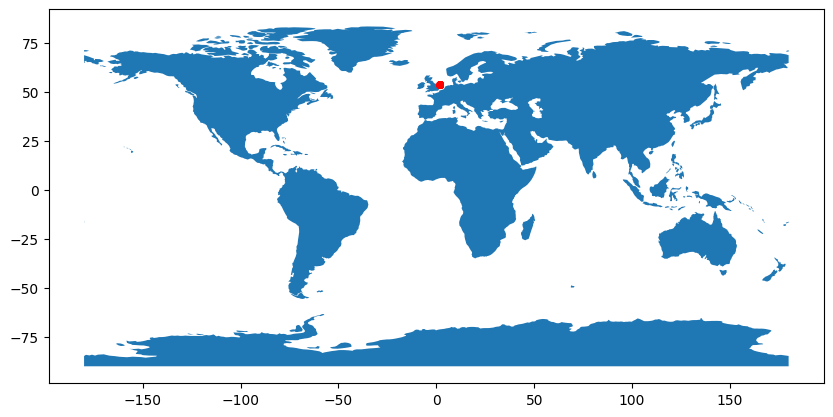

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets

df1_ = hornsea[["longitude", "latitude"]].drop_duplicates()

geometry = [Point(xy) for xy in zip(df1_['longitude'], df1_['latitude'])]
gdf = GeoDataFrame(df1_, geometry=geometry)   

#this is a simple map that goes with geopandas
# deprecated: world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

<Axes: >

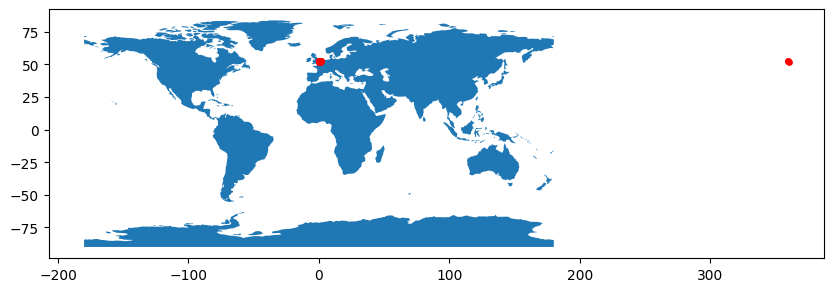

In [23]:
df2_ = pes.reset_index()[["longitude", "latitude"]].drop_duplicates()

geometry = [Point(xy) for xy in zip(df2_['longitude'], df2_['latitude'])]
gdf = GeoDataFrame(df2_, geometry=geometry)   

#this is a simple map that goes with geopandas
# deprecated: world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

<Axes: >

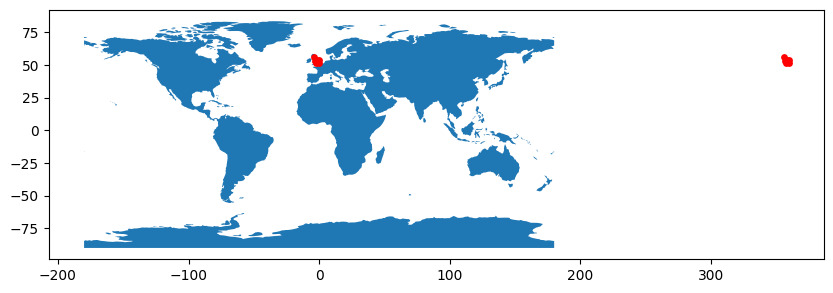

In [24]:
df3_ = demand.reset_index()[["longitude", "latitude"]].drop_duplicates()

geometry = [Point(xy) for xy in zip(df3_['longitude'], df3_['latitude'])]
gdf = GeoDataFrame(df3_, geometry=geometry)   

#this is a simple map that goes with geopandas
# deprecated: world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

## .JSON Dateien ##

In den JSON-Dateien befinden sich Informationen zu (un-)geplanten Ausfällen auf der Windkraftanlage HORNSEA.

In [25]:
import json

def extract_json_files(path):

    json_data = None

    for file in os.listdir(path):

        with open(path + "/" + file) as f:
            d = json.load(f)
            d = pd.json_normalize(d)

        if type(json_data) == type(None):
            json_data = d
        else:
            json_data = pd.concat([json_data, d])

    return json_data

json_data = extract_json_files("nc_files/REMIT")

In [26]:
json_data.head(5)

id dataset                                mrid  revisionNumber  \
0  17116   REMIT  11XDONG-PT-----2-NGET-RMT-00001689               1   
1  17326   REMIT  11XDONG-PT-----2-NGET-RMT-00001689               2   
2  17618   REMIT  11XDONG-PT-----2-NGET-RMT-00001695               1   
3  18969   REMIT  11XDONG-PT-----2-NGET-RMT-00001695               2   
4  19014   REMIT  11XDONG-PT-----2-NGET-RMT-00001701               1   

            publishTime           createdTime  \
0  2023-07-17T10:42:04Z  2023-07-17T10:35:00Z   
1  2023-07-18T14:12:03Z  2023-07-18T14:07:00Z   
2  2023-07-20T03:06:40Z  2023-07-19T07:50:00Z   
3  2023-07-24T07:00:04Z  2023-07-24T06:55:00Z   
4  2023-07-24T11:00:04Z  2023-07-24T10:55:00Z   

                               messageType     messageHeading  \
0  UnavailabilitiesOfElectricityFacilities  REMIT Information   
1  UnavailabilitiesOfElectricityFacilities  REMIT Information   
2  UnavailabilitiesOfElectricityFacilities  REMIT Information   
3  UnavailabilitiesOfElectricityFacilities  REMIT Information   
4  UnavailabilitiesOfElectricityFacilities  REMIT Information   

                   eventType unavailabilityType  ...       fuelType  \
0  Production unavailability            Planned  ...  Wind Offshore   
1  Production unavailability            Planned  ...  Wind Offshore   
2  Production unavailability            Planned  ...  Wind Offshore   
3  Production unavailability            Planned  ...  Wind Offshore   
4  Production unavailability            Planned  ...  Wind Offshore   

  normalCapacity availableCapacity unavailableCapacity eventStatus  \
0            400                 0                 400      Active   
1            400                 0                 400      Active   
2            400                 0                 400      Active   
3            400                 0                 400      Active   
4            400                 0                 400      Active   

         eventStartTime          eventEndTime           cause  \
0  2023-07-18T08:00:00Z  2023-07-18T14:00:00Z  Planned Outage   
1  2023-07-18T08:00:00Z  2023-07-18T16:00:00Z  Planned Outage   
2  2023-07-24T06:00:00Z  2023-07-24T14:00:00Z  Planned Outage   
3  2023-07-24T06:00:00Z  2023-07-24T08:00:00Z  Planned Outage   
4  2023-07-25T06:00:00Z  2023-07-25T14:00:00Z  Planned Outage   

                                       outageProfile  relatedInformation  
0  [{'startTime': '2023-07-18T08:00:00Z', 'endTim...                 NaN  
1  [{'startTime': '2023-07-18T08:00:00Z', 'endTim...                 NaN  
2  [{'startTime': '2023-07-24T06:00:00Z', 'endTim...                 NaN  
3  [{'startTime': '2023-07-24T06:00:00Z', 'endTim...                 NaN  
4  [{'startTime': '2023-07-25T06:00:00Z', 'endTim...                 NaN  

[5 rows x 28 columns]

In [27]:
df_outage = pd.DataFrame()

for id, x in json_data[["id", "outageProfile"]].iterrows():
    now_id = x["id"]
    for y in x["outageProfile"]:
        y["id"] = now_id
        df_outage = pd.concat([df_outage, pd.json_normalize(y)])

In [28]:
df_outage

startTime               endTime  capacity      id
0   2023-07-18T08:00:00Z  2023-07-18T14:00:00Z         0   17116
0   2023-07-18T08:00:00Z  2023-07-18T16:00:00Z         0   17326
0   2023-07-24T06:00:00Z  2023-07-24T14:00:00Z         0   17618
0   2023-07-24T06:00:00Z  2023-07-24T08:00:00Z         0   18969
0   2023-07-25T06:00:00Z  2023-07-25T14:00:00Z         0   19014
..                   ...                   ...       ...     ...
0   2024-02-23T18:00:00Z  2024-02-23T19:00:00Z         0  725348
0   2024-02-23T19:00:00Z  2024-04-30T17:00:00Z       150  725348
0   2024-01-29T02:10:00Z  2024-02-23T18:00:00Z       150  733271
0   2024-02-23T18:00:00Z  2024-02-23T19:00:00Z         0  733271
0   2024-02-23T19:00:00Z  2024-05-26T19:00:00Z       150  733271

[250 rows x 4 columns]

Die JSON-Datei enthält Informationen zu geplanten oder unerwarteten Ausfällen in der Windkraftanlage HORNSEA. Jede Zeile beschreibt einen Vorfall und dessen Beginn und Abschluss. 

Daher wird jede Zeile genutzt, um aus der Dauer zwischen Anfang und Beginn eines Ausfalls ein Zeitintervallindex zu erstellen mit einem Intervall von 30 Minuten. Anschließend wird dieser neue Datensatz mit den HORNSEA-Daten zusammengefügt.

In [29]:
def preprocess_outage_data(json_data):
    # dismissed outages are not relevant
    json_data = json_data[json_data.eventStatus != "Dismissed"]
    # drop those columns since they provide no value as features
    json_data.drop(columns = ["id", "outageProfile", "assetId", "affectedUnitEIC", "dataset", "eventStatus", "cause", "publishTime", "createdTime", "relatedInformation", "revisionNumber"], axis = 1, inplace = True)

    # drop string value columns with only one unique value
    for col in json_data.columns:
        if json_data[col].nunique() == 1 and json_data[col].dtypes == "O":
            try:
                json_data.drop(columns = col, inplace = True, axis = 1)
            except:
                continue

    # convert the datetime information to the right format
    for col in ["eventStartTime", "eventEndTime"]:
        json_data[col] = pd.to_datetime(json_data[col])


    outages_df = pd.DataFrame(columns = json_data.columns)

    # the outages contain start and end times for each outage. With this for loop we create for each 30min interval a new row and add it to the dataframe.
    # We basically include every time period inside of an outage in 30min periods.
    for row in json_data.iterrows():
        dates_30min_freq = pd.date_range(start = row[1]["eventStartTime"], end = row[1]["eventEndTime"], freq = "30min", inclusive = "both")
        json_data_with_date_ranges = pd.DataFrame(index = dates_30min_freq, columns = json_data.columns)
        json_data_with_date_ranges.iloc[:] = row[1]
        json_data_with_date_ranges = json_data_with_date_ranges.infer_objects(copy=False)
        outages_df = pd.concat([outages_df, json_data_with_date_ranges])


    # create new features for the outages
    outages_df["hoursSinceOutage"] = (outages_df.index - outages_df.eventStartTime).div(pd.Timedelta("1h"))
    outages_df["hoursUntilOutageEnd"] = (outages_df.eventEndTime - outages_df.index).div(pd.Timedelta("1h"))
    outages_df["outage"] = True
    outages_df["mrid"] = outages_df["mrid"].str.split("-").str[-1]

    outages_df.drop(columns = ["eventStartTime", "eventEndTime"], axis = 1, inplace = True)

    return outages_df

outages_df = preprocess_outage_data(json_data)


C:\Users\danie\AppData\Local\Temp\ipykernel_37556\3353469543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_data.drop(columns = ["id", "outageProfile", "assetId", "affectedUnitEIC", "dataset", "eventStatus", "cause", "publishTime", "createdTime", "relatedInformation", "revisionNumber"], axis = 1, inplace = True)
C:\Users\danie\AppData\Local\Temp\ipykernel_37556\3353469543.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_data.drop(columns = col, inplace = True, axis = 1)
C:\Users\danie\AppData\Local\Temp\ipykernel_37556\3353469543.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [30]:
import plotly.express as px

px.scatter(outages_df[["affectedUnit", "unavailabilityType"]], color = "unavailabilityType", title = "Ausfallszeiträume der HORNSEA-Windkraftanlagen")

## .csv Dateien ##

In [31]:
import pandas as pd
import os

In [32]:
df_energy = combine_files("csv_files", "Energy_data", ".csv")

Energy_Data_20200920_20231027.csv
Energy_Data_20200920_20240118.csv
Energy_Data_20240119_20240519.csv


In [33]:
df_energy.head()

dtm    MIP  Solar_MW  Solar_capacity_mwp  \
0  2020-09-20T00:00:00Z  20.06       0.0         2108.489754   
1  2020-09-20T00:30:00Z  19.77       0.0         2108.489754   
2  2020-09-20T01:00:00Z  28.68       0.0         2108.489754   
3  2020-09-20T01:30:00Z  28.97       0.0         2108.489754   
4  2020-09-20T02:00:00Z  28.19       0.0         2108.489754   

   Solar_installedcapacity_mwp  Wind_MW  SS_Price  boa_MWh  DA_Price  
0                  2206.064655  996.284      2.50      0.0     32.17  
1                  2206.064655  957.576     15.00      0.0     32.17  
2                  2206.064655  941.044     47.95      0.0     32.00  
3                  2206.064655  964.366     29.13      0.0     32.00  
4                  2206.064655  918.432     28.95      0.0     31.99

In [34]:
from datetime import datetime
from math import sin, cos, pi


def cyclic_sin(n):
    theta = 2 * pi * n
    return sin(theta)

def cyclic_cos(n):
    theta = 2 * pi * n
    return cos(theta)

def get_cycles(d, sin_or_cos:int, time_information:str):
    '''
    Get the cyclic properties of a datetime,
    represented as points on the unit circle.
    Arguments
    ---------
    d : datetime object
    Returns
    -------
    dictionary of sine and cosine tuples

    source: https://medium.com/@dan.allison/how-to-encode-the-cyclic-properties-of-time-with-python-6f4971d245c0
    '''
    month = d.month - 1
    day = d.day - 1

    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    if sin_or_cos == 0:
        if time_information.lower() == "month":
            return cyclic_sin(month / 12)
        elif time_information.lower() == "day":
            return cyclic_sin(day / days_in_month[month])
        elif time_information.lower() == "dayofweek":
            return cyclic_sin(d.weekday() / 7)
        elif time_information.lower() == "hour":
            return cyclic_sin(d.hour / 60)
        elif time_information.lower() == "minute":
            return cyclic_sin(d.minute / 60)
        else:
            return
    elif sin_or_cos == 1:
        if time_information.lower() == "month":
            return cyclic_cos(month / 12)
        elif time_information.lower() == "day":
            return cyclic_cos(day / days_in_month[month])
        elif time_information.lower() == "dayofweek":
            return cyclic_cos(d.weekday() / 7)
        elif time_information.lower() == "hour":
            return cyclic_cos(d.hour / 24)
        elif time_information.lower() == "minute":
            return cyclic_cos(d.minute / 60)
        else:
            return

In [35]:
def preprocess_energy_data(df_energy):
    # convert the datetime information to the right format
    df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])

    # Group by year, month, and hour, then calculate the mean
    grouped_means = df_energy.groupby([df_energy.dtm.dt.year, df_energy.dtm.dt.month, df_energy.dtm.dt.hour]).transform('mean')

    # Fill missing values in df_energy with the corresponding grouped means
    df_energy = df_energy.fillna(grouped_means)

    # convert MW to MWh (30min periods --> multiply by 0.5)
    for col in ["Solar_MW", "Wind_MW"]:
        df_energy[col] = 0.5 * df_energy[col]

    df_energy["Wind_MWh_credit"] = df_energy["Wind_MW"] - df_energy["boa_MWh"]
    df_energy.rename(columns = {"Solar_MW": "Solar_MWh_credit", "Wind_MW": "Wind_MWh"}, inplace = True)


    for col in ["month", "day", "dayofweek", "hour", "minute"]:
        time_col_sin = "sin_" + col
        time_col_cos = "cos_" + col

        df_energy[time_col_sin] = df_energy.dtm.apply(get_cycles, args = (0, col))
        df_energy[time_col_cos] = df_energy.dtm.apply(get_cycles, args = (1, col))

    return df_energy

df_energy = preprocess_energy_data(df_energy)


Kombination von csv- und JSON-Dateien

In [36]:
pd.set_option('future.no_silent_downcasting', True)

def merge_energy_with_outages(energy_data, outage_data):
    energy_with_outages = pd.merge_asof(left = energy_data, right = outage_data, left_on = "dtm", right_on = outage_data.sort_index().index, direction = "nearest", tolerance = pd.Timedelta("30m"))

    # the merge will result in NA values (since outages are not present all the time), thus they have to be filled with replacement values
    energy_with_outages[["mrid", "affectedUnit", "unavailabilityType"]] = energy_with_outages[["mrid", "affectedUnit", "unavailabilityType"]].fillna("None")
    energy_with_outages[["unavailableCapacity", "hoursSinceOutage", "hoursUntilOutageEnd"]] = energy_with_outages[["unavailableCapacity", "hoursSinceOutage", "hoursUntilOutageEnd"]].fillna(0)
    energy_with_outages[["normalCapacity", "availableCapacity"]] = energy_with_outages[["normalCapacity", "availableCapacity"]].fillna(400)
    energy_with_outages["outage"] = energy_with_outages["outage"].fillna(False)

    return energy_with_outages

energy_with_outages = merge_energy_with_outages(df_energy, outages_df)

In [37]:
energy_with_outages.head()

dtm    MIP  Solar_MWh_credit  Solar_capacity_mwp  \
0 2020-09-20 00:00:00+00:00  20.06               0.0         2108.489754   
1 2020-09-20 00:30:00+00:00  19.77               0.0         2108.489754   
2 2020-09-20 01:00:00+00:00  28.68               0.0         2108.489754   
3 2020-09-20 01:30:00+00:00  28.97               0.0         2108.489754   
4 2020-09-20 02:00:00+00:00  28.19               0.0         2108.489754   

   Solar_installedcapacity_mwp  Wind_MWh  SS_Price  boa_MWh  DA_Price  \
0                  2206.064655   498.142      2.50      0.0     32.17   
1                  2206.064655   478.788     15.00      0.0     32.17   
2                  2206.064655   470.522     47.95      0.0     32.00   
3                  2206.064655   482.183     29.13      0.0     32.00   
4                  2206.064655   459.216     28.95      0.0     31.99   

   Wind_MWh_credit  ...  cos_minute  mrid  unavailabilityType  affectedUnit  \
0          498.142  ...         1.0  None                None          None   
1          478.788  ...        -1.0  None                None          None   
2          470.522  ...         1.0  None                None          None   
3          482.183  ...        -1.0  None                None          None   
4          459.216  ...         1.0  None                None          None   

   normalCapacity  availableCapacity  unavailableCapacity  hoursSinceOutage  \
0             400                400                    0               0.0   
1             400                400                    0               0.0   
2             400                400                    0               0.0   
3             400                400                    0               0.0   
4             400                400                    0               0.0   

   hoursUntilOutageEnd  outage  
0                  0.0   False  
1                  0.0   False  
2                  0.0   False  
3                  0.0   False  
4                  0.0   False  

[5 rows x 29 columns]

Kombination mit CDF-Dateien

In [35]:
hornsea = hornsea.set_index(["reference_time", "valid_time", "latitude", "longitude"])
merged_hornsea = pd.merge_asof(hornsea.sort_values("valid_time"), energy_with_outages, left_on = "valid_time", right_on = "dtm", direction = "nearest", tolerance = pd.Timedelta("15min"))
print(merged_hornsea.shape)
merged_hornsea = merged_hornsea.dropna(axis = 0)

(25727886, 35)


In [36]:
merged_pes = pd.merge_asof(pes.sort_values("valid_time"), energy_with_outages, left_on = "valid_time", right_on = "dtm", direction = "nearest", tolerance = pd.Timedelta("15min"))
print(merged_pes.shape)
merged_pes = merged_pes.dropna(axis = 0)

(20830447, 32)


In [37]:
merged_demand = pd.merge_asof(demand.sort_values("valid_time"), energy_with_outages, left_on = "valid_time", right_on = "dtm", direction = "nearest", tolerance = pd.Timedelta("15min"))
print(merged_demand.shape)
merged_demand = merged_demand.dropna(axis = 0)

(7520002, 35)


In [38]:
pes.isnull().sum()

CloudCover                0
SolarDownwardRadiation    0
Temperature               0
dtype: int64

In [39]:
# pes[pes.isna().any(axis = 1)].shape[0]/pes.shape[0]
# demand[demand.isna().any(axis = 1)].shape[0]/demand.shape[0]
# hornsea[hornsea.isna().any(axis = 1)].shape[0]/hornsea.shape[0]

In [40]:
merged_demand.columns

Index(['point', 'RelativeHumidity', 'Temperature', 'TotalPrecipitation',
       'WindDirection', 'WindSpeed', 'dtm', 'MIP', 'Solar_MWh_credit',
       'Solar_capacity_mwp', 'Solar_installedcapacity_mwp', 'Wind_MWh',
       'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit', 'sin_month',
       'cos_month', 'sin_day', 'cos_day', 'sin_dayofweek', 'cos_dayofweek',
       'sin_hour', 'cos_hour', 'sin_minute', 'cos_minute', 'mrid',
       'unavailabilityType', 'affectedUnit', 'normalCapacity',
       'availableCapacity', 'unavailableCapacity', 'hoursSinceOutage',
       'hoursUntilOutageEnd', 'outage'],
      dtype='object')

In [127]:
for col in ['RelativeHumidity', 'Temperature', 'TotalPrecipitation',
       'WindDirection', 'WindSpeed', 'MIP', 'Solar_MWh_credit',
       'Solar_capacity_mwp', 'Solar_installedcapacity_mwp', 'Wind_MWh_credit',
       'SS_Price', 'boa_MWh', 'DA_Price', 'normalCapacity',
       'availableCapacity', 'unavailableCapacity',
       'CloudCover', 'SolarDownwardRadiation', 'Temperature',
       'MIP',
       'Solar_MWh_credit', 'Solar_capacity_mwp', 'Solar_installedcapacity_mwp',
       'Wind_MWh', 'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit']:
    
    new_col = col + "_diff"
    if col in merged_demand.columns:
      merged_demand[new_col] = merged_demand[col].diff()
      merged_demand.loc[0, new_col] = 0
    if col in merged_hornsea.columns:
      merged_hornsea[new_col] = merged_hornsea[col].diff()
      merged_hornsea.loc[0, new_col] = 0
    if col in merged_pes.columns:
      merged_pes[new_col] = merged_pes[col].diff()
      merged_pes.loc[0, new_col] = 0


In [42]:
for col in pes.columns:
    print(col)
    print(pes[col].min())
    print(pes[col].max())

CloudCover
0.0
1.0
SolarDownwardRadiation
-0.5543136596679688
1704.97998046875
Temperature
-10.213715
42.94818


In [43]:
for col in demand.columns:
    print(col)
    print(demand[col].min())
    print(demand[col].max())

point
0.0
6.0
RelativeHumidity
8.6
100.00097
Temperature
-14.835144
41.808136
TotalPrecipitation
-0.00390625
29.741758346557617
WindDirection
0.00033569336
359.99954
WindSpeed
0.0018408463
23.195795


In [44]:
demand[demand.TotalPrecipitation < 0]

point  \
reference_time            valid_time                latitude longitude          
2020-09-20 12:00:00+00:00 2020-09-25 06:00:00+00:00 51.453   -2.600       1.0   
                                                    51.479   -0.451       0.0   
2020-09-20 18:00:00+00:00 2020-09-25 09:00:00+00:00 51.453   -2.600       1.0   
2020-09-21 06:00:00+00:00 2020-09-21 22:00:00+00:00 55.860   -4.264       4.0   
                          2020-09-22 21:00:00+00:00 52.449   -1.926       2.0   
...                                                                       ...   
2024-05-18 18:00:00+00:00 2024-05-18 20:00:00+00:00 52.449   -1.926       2.0   
                          2024-05-18 21:00:00+00:00 51.453   -2.600       1.0   
                          2024-05-20 05:00:00+00:00 51.453   -2.600       1.0   
                                                    55.860   -4.264       4.0   
2024-05-19 00:00:00+00:00 2024-05-20 05:00:00+00:00 51.479   -0.451       0.0   

                                                                        RelativeHumidity  \
reference_time            valid_time                latitude longitude                     
2020-09-20 12:00:00+00:00 2020-09-25 06:00:00+00:00 51.453   -2.600            84.161850   
                                                    51.479   -0.451            87.776299   
2020-09-20 18:00:00+00:00 2020-09-25 09:00:00+00:00 51.453   -2.600            69.814972   
2020-09-21 06:00:00+00:00 2020-09-21 22:00:00+00:00 55.860   -4.264            87.804672   
                          2020-09-22 21:00:00+00:00 52.449   -1.926            80.156532   
...                                                                                  ...   
2024-05-18 18:00:00+00:00 2024-05-18 20:00:00+00:00 52.449   -1.926            67.667061   
                          2024-05-18 21:00:00+00:00 51.453   -2.600            91.914574   
                          2024-05-20 05:00:00+00:00 51.453   -2.600            79.911530   
                                                    55.860   -4.264            83.128326   
2024-05-19 00:00:00+00:00 2024-05-20 05:00:00+00:00 51.479   -0.451            90.661385   

                                                                        Temperature  \
reference_time            valid_time                latitude longitude                
2020-09-20 12:00:00+00:00 2020-09-25 06:00:00+00:00 51.453   -2.600        7.889267   
                                                    51.479   -0.451        8.066193   
2020-09-20 18:00:00+00:00 2020-09-25 09:00:00+00:00 51.453   -2.600       10.576904   
2020-09-21 06:00:00+00:00 2020-09-21 22:00:00+00:00 55.860   -4.264       11.059708   
                          2020-09-22 21:00:00+00:00 52.449   -1.926       15.656418   
...                                                                             ...   
2024-05-18 18:00:00+00:00 2024-05-18 20:00:00+00:00 52.449   -1.926       17.303284   
                          2024-05-18 21:00:00+00:00 51.453   -2.600       15.318604   
                          2024-05-20 05:00:00+00:00 51.453   -2.600       10.235626   
                                                    55.860   -4.264       11.416290   
2024-05-19 00:00:00+00:00 2024-05-20 05:00:00+00:00 51.479   -0.451        9.621765   

                                                                        TotalPrecipitation  \
reference_time            valid_time                latitude longitude                       
2020-09-20 12:00:00+00:00 2020-09-25 06:00:00+00:00 51.453   -2.600              -0.000651   
                                                    51.479   -0.451              -0.000651   
2020-09-20 18:00:00+00:00 2020-09-25 09:00:00+00:00 51.453   -2.600              -0.000651   
2020-09-21 06:00:00+00:00 2020-09-21 22:00:00+00:00 55.860   -4.264              -0.000488   
                          2020-09-22 21:00:00+00:00 52.449   -1.926              -0.000977   
...                            

In [45]:
demand.reset_index()[["latitude", "longitude", "point"]].drop_duplicates()

latitude  longitude  point
0          51.453     -2.600    1.0
1          51.479     -0.451    0.0
2          52.449     -1.926    2.0
3          53.175     -2.986    3.0
4          53.875     -0.442    5.0
5          54.297     -1.533    6.0
6          55.860     -4.264    4.0
6624304    51.453    357.400    1.0
6624306    51.479    359.549    0.0
6624308    52.449    358.074    2.0
6624310    53.175    357.014    3.0
6624312    53.875    359.558    5.0
6624314    54.297    358.467    6.0
6624316    55.860    355.736    4.0

In [47]:
merged_hornsea.columns

Index(['RelativeHumidity', 'Temperature', 'WindDirection', 'WindDirection:100',
       'WindSpeed', 'WindSpeed:100', 'dtm', 'MIP', 'Solar_MWh_credit',
       'Solar_capacity_mwp', 'Solar_installedcapacity_mwp', 'Wind_MWh',
       'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit', 'sin_month',
       'cos_month', 'sin_day', 'cos_day', 'sin_dayofweek', 'cos_dayofweek',
       'sin_hour', 'cos_hour', 'sin_minute', 'cos_minute', 'mrid',
       'unavailabilityType', 'affectedUnit', 'normalCapacity',
       'availableCapacity', 'unavailableCapacity', 'hoursSinceOutage',
       'hoursUntilOutageEnd', 'outage', 'RelativeHumidity_diff',
       'Temperature_diff', 'WindDirection_diff', 'WindSpeed_diff', 'MIP_diff',
       'Solar_MWh_credit_diff', 'Solar_capacity_mwp_diff',
       'Solar_installedcapacity_mwp_diff', 'Wind_MWh_credit_diff',
       'SS_Price_diff', 'boa_MWh_diff', 'DA_Price_diff', 'normalCapacity_diff',
       'availableCapacity_diff', 'unavailableCapacity_diff', 'Wind_MWh_diff'

<Axes: xlabel='WindSpeed', ylabel='Wind_MWh'>

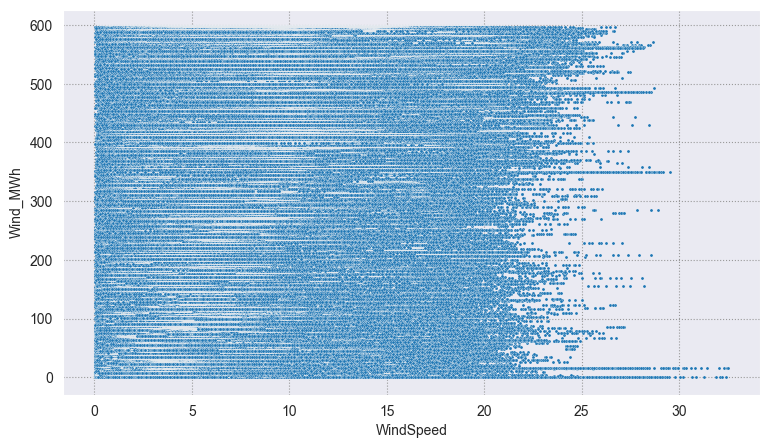

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,5))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(merged_hornsea, x = "WindSpeed", y = "Wind_MWh", s = 5)

<Axes: xlabel='WindSpeed:100', ylabel='Wind_MWh'>

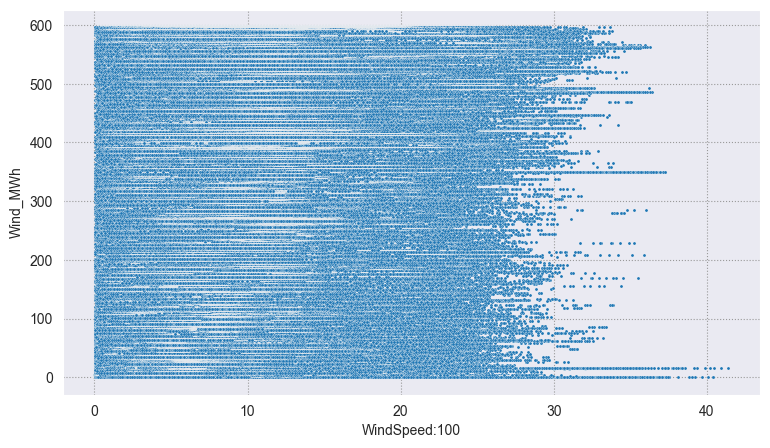

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,5))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(merged_hornsea, x = "WindSpeed:100", y = "Wind_MWh", s = 5)

In [112]:
merged_hornsea.columns

Index(['RelativeHumidity', 'Temperature', 'WindDirection', 'WindDirection:100',
       'WindSpeed', 'WindSpeed:100', 'dtm', 'MIP', 'Solar_MWh_credit',
       'Solar_capacity_mwp', 'Solar_installedcapacity_mwp', 'Wind_MWh',
       'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit', 'sin_month',
       'cos_month', 'sin_day', 'cos_day', 'sin_dayofweek', 'cos_dayofweek',
       'sin_hour', 'cos_hour', 'sin_minute', 'cos_minute', 'mrid',
       'unavailabilityType', 'affectedUnit', 'normalCapacity',
       'availableCapacity', 'unavailableCapacity', 'hoursSinceOutage',
       'hoursUntilOutageEnd', 'outage', 'RelativeHumidity_diff',
       'Temperature_diff', 'WindDirection_diff', 'WindSpeed_diff', 'MIP_diff',
       'Solar_MWh_credit_diff', 'Solar_capacity_mwp_diff',
       'Solar_installedcapacity_mwp_diff', 'Wind_MWh_credit_diff',
       'SS_Price_diff', 'boa_MWh_diff', 'DA_Price_diff', 'normalCapacity_diff',
       'availableCapacity_diff', 'unavailableCapacity_diff', 'Wind_MWh_diff'

<Axes: xlabel='SolarDownwardRadiation', ylabel='Solar_MWh_credit'>

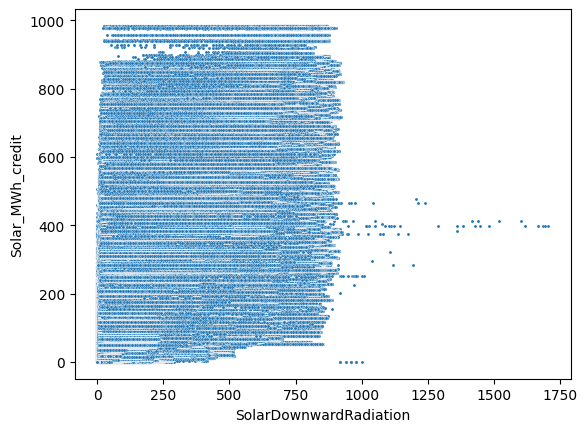

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(merged_pes, x = "SolarDownRadiation", y = "Solar_MWh_credit", s = 5)

<Axes: xlabel='SolarDownwardRadiation', ylabel='Solar_MWh_credit'>

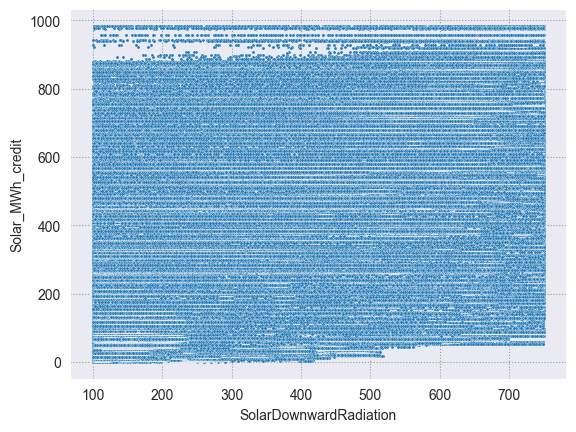

In [108]:
sns.scatterplot(merged_pes[(merged_pes.SolarDownwardRadiation > 0)], x = "SolarDownwardRadiation", y = "Solar_MWh_credit", s = 5)

In [54]:
merged_pes.columns

Index(['CloudCover', 'SolarDownwardRadiation', 'Temperature', 'dtm', 'MIP',
       'Solar_MWh_credit', 'Solar_capacity_mwp', 'Solar_installedcapacity_mwp',
       'Wind_MWh', 'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit',
       'sin_month', 'cos_month', 'sin_day', 'cos_day', 'sin_dayofweek',
       'cos_dayofweek', 'sin_hour', 'cos_hour', 'sin_minute', 'cos_minute',
       'mrid', 'unavailabilityType', 'affectedUnit', 'normalCapacity',
       'availableCapacity', 'unavailableCapacity', 'hoursSinceOutage',
       'hoursUntilOutageEnd', 'outage', 'Temperature_diff', 'MIP_diff',
       'Solar_MWh_credit_diff', 'Solar_capacity_mwp_diff',
       'Solar_installedcapacity_mwp_diff', 'Wind_MWh_credit_diff',
       'SS_Price_diff', 'boa_MWh_diff', 'DA_Price_diff', 'normalCapacity_diff',
       'availableCapacity_diff', 'unavailableCapacity_diff', 'CloudCover_diff',
       'SolarDownwardRadiation_diff', 'Wind_MWh_diff'],
      dtype='object')

<Axes: xlabel='dtm', ylabel='DA_Price'>

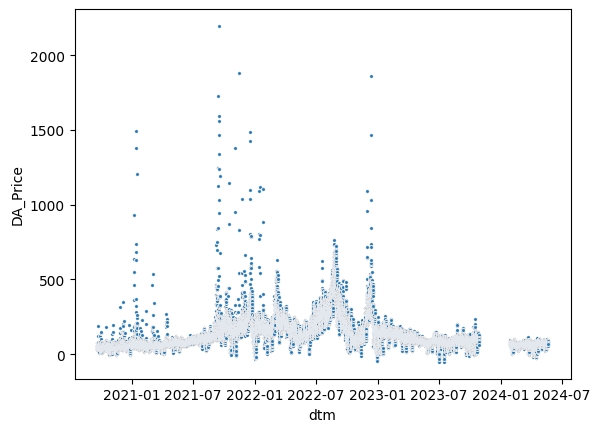

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(merged_hornsea, x = "dtm", y = "DA_Price", s = 5)

Features und Labels

Forecasting: Solar_MWh, Wind_MWh

Trading: Handelbarer Strom